<a href="https://colab.research.google.com/github/MayaHayat/Intel_Classification/blob/main/Intel_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intel Image Classification

By Aviya Oren and Maya Hayat

This Data contains around 25k images of size 150x150 distributed under 6 categories.
1. 'buildings'
2. 'forest'
3. 'glacier'
4. 'mountain'
5. 'sea'
6. 'street'

In [5]:
import numpy as np
import pandas as pd
import os
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from PIL import Image
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import random

import cv2
import imghdr

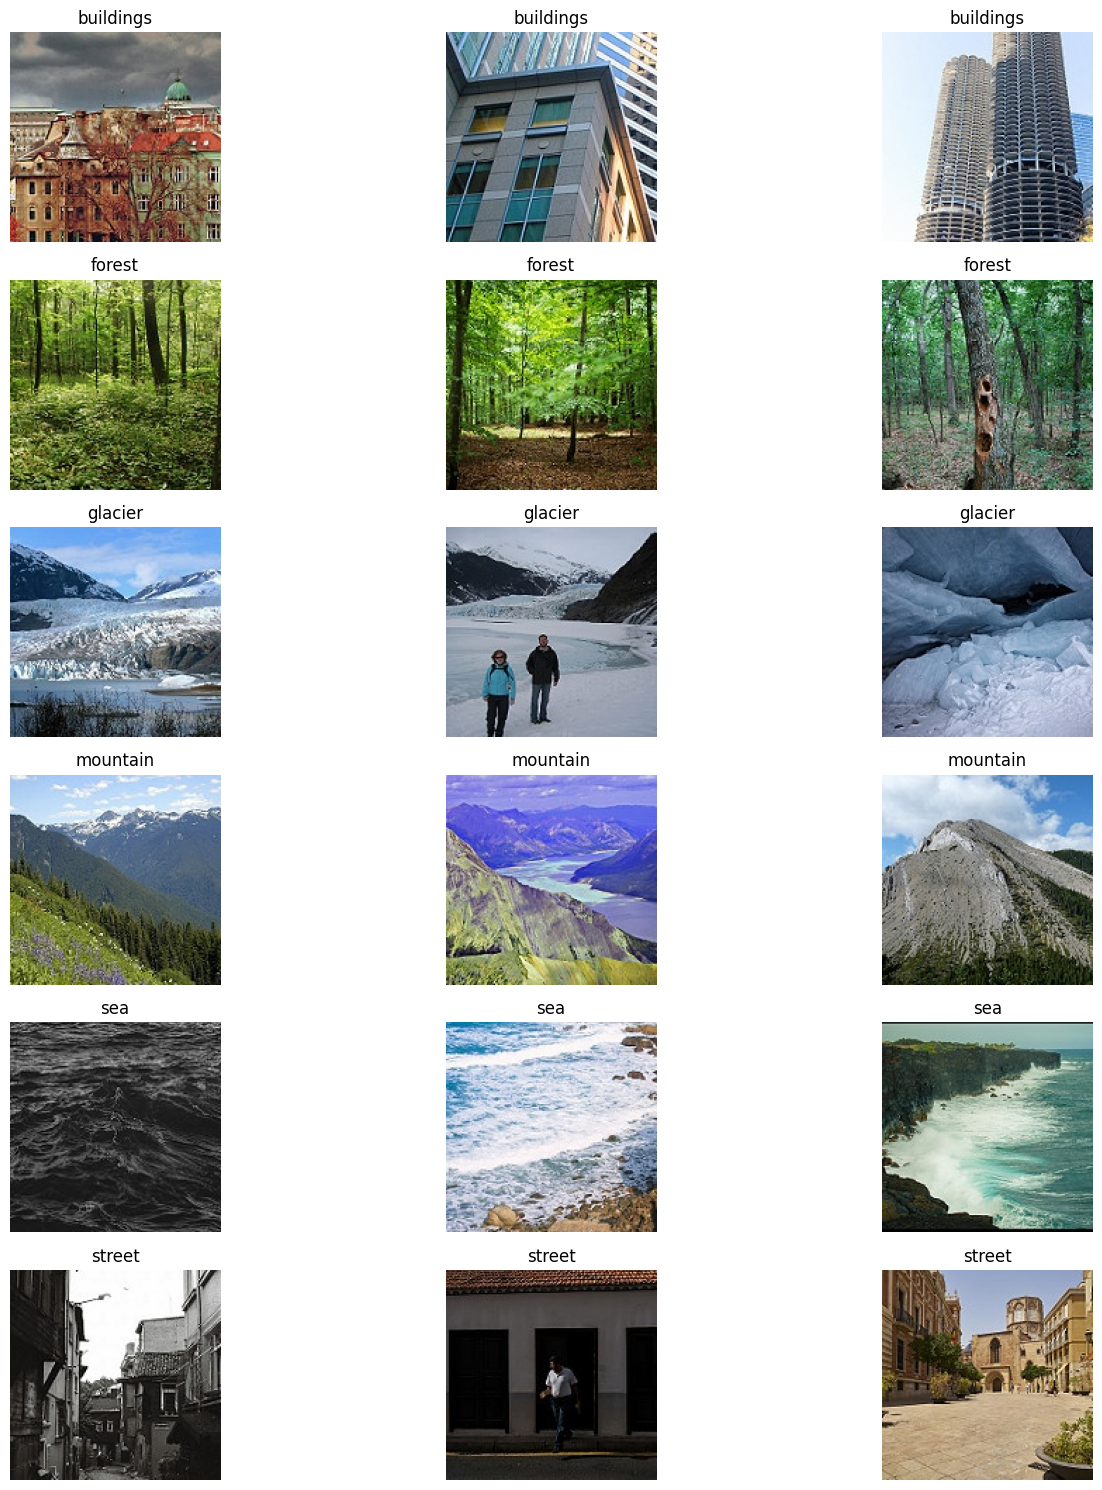

In [3]:
# Path to the directory containing the images
base_directory = '/content/drive/MyDrive/IntelClassification/seg_train'

# Categories
categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Display three random images for each category
fig, axs = plt.subplots(len(categories), 3, figsize=(15, 15))

for i, category in enumerate(categories):
    category_directory = os.path.join(base_directory, category)
    files = os.listdir(category_directory)
    image_files = [file for file in files if file.endswith(('png', 'jpg', 'jpeg'))]
    random_images = random.sample(image_files, 3)

    for j, image_file in enumerate(random_images):
        image_path = os.path.join(category_directory, image_file)
        image = mpimg.imread(image_path)
        axs[i, j].imshow(image)
        axs[i, j].axis('off')
        axs[i, j].set_title(category)

plt.tight_layout()
plt.show()


In [44]:
data_directory = '/content/drive/MyDrive/IntelClassification/seg_train'

In [45]:
os.listdir(data_directory)

['forest', 'buildings', 'street', 'sea', 'mountain', 'glacier']

In [46]:
# According to Kaggle the original size if 150*150, therefore we want to keep it as is
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/IntelClassification/seg_train', image_size = (150,150))

Found 14034 files belonging to 6 classes.


In [47]:
data_iterator = data.as_numpy_iterator()

In [48]:
batch = data_iterator.next()

In [49]:
# where the first batch is our data and the second is the labels
len(batch)

2

In [50]:
batch[0].shape

(32, 150, 150, 3)

In [19]:
batch[1]

array([2, 2, 0, 3, 1, 4, 5, 1, 4, 1, 3, 5, 0, 0, 2, 5, 2, 4, 5, 5, 0, 0,
       0, 2, 3, 0, 4, 1, 3, 3, 4, 5], dtype=int32)

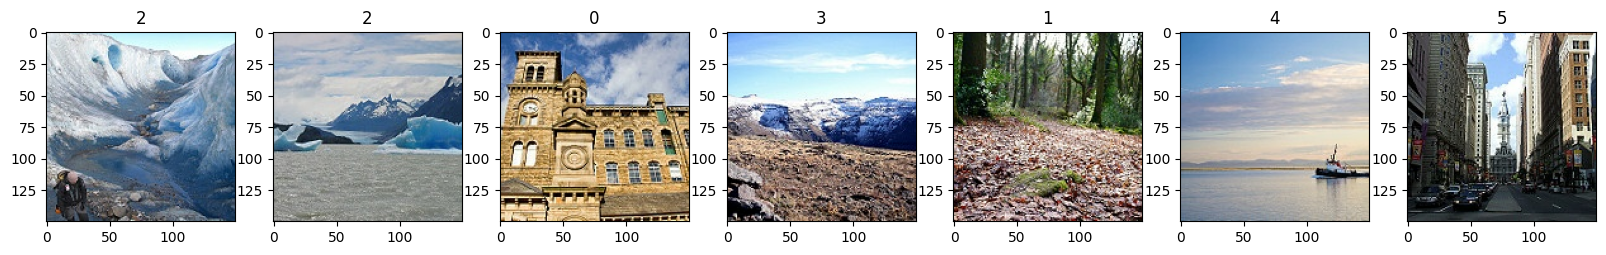

In [32]:
fig, ax = plt.subplots(ncols=7, figsize=(20,20))
for idx, img in enumerate(batch[0][:7]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

As we can see above the following numbers match the following catagories:
0. building
1. forest
2. glacier
3. mountain
4. sea
5. street

In [51]:
print("max:" , batch[0].max(), " and min: ", batch[0].min())

max: 255.0  and min:  0.0


In [52]:
data = data.map(lambda x, y: (x / 255.0, y))


In [56]:
data.as_numpy_iterator().next()[0].max(), data.as_numpy_iterator().next()[0].min()

(1.0, 0.0)

In [58]:
# Number of batches * 32 images
len(data)

439

In [64]:
train_size = int(len(data)*0.6)+2
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.2)
print("train size:" , train_size, ",test size:", test_size,",val size:", val_size)

train size: 265 ,test size: 87 ,val size: 87


In [65]:
train = data.take(train_size)
test = data.skip(train_size).take(test_size)
val = data.skip(train_size + test_size).take(val_size)

In [66]:
len(train)

265

In [68]:
model= tf.keras.Sequential([
    # First layer
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    # Second layer
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Third layer
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [69]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [70]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 32)        18464     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 17, 17, 32)       

In [72]:
logdir = '/content/drive/MyDrive/IntelClassification/logs'

In [73]:
callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [74]:
history = model.fit(train, epochs=8, validation_data = val, callbacks=[callback])

265/265 [==============================] - 1120s 4s/step - loss: 1.0715 - accuracy: 0.5742 - val_loss: 0.8261 - val_accuracy: 0.6935
Epoch 2/8
265/265 [==============================] - 69s 257ms/step - loss: 0.7668 - accuracy: 0.7108 - val_loss: 0.7312 - val_accuracy: 0.7184
Epoch 3/8
265/265 [==============================] - 68s 255ms/step - loss: 0.6128 - accuracy: 0.7765 - val_loss: 0.6424 - val_accuracy: 0.7715
Epoch 4/8
265/265 [==============================] - 109s 412ms/step - loss: 0.4963 - accuracy: 0.8213 - val_loss: 0.6456 - val_accuracy: 0.7809
Epoch 5/8
265/265 [==============================] - 68s 256ms/step - loss: 0.4109 - accuracy: 0.8495 - val_loss: 0.7173 - val_accuracy: 0.7679
Epoch 6/8
265/265 [==============================] - 109s 410ms/step - loss: 0.3200 - accuracy: 0.8828 - val_loss: 0.7732 - val_accuracy: 0.7386
Epoch 7/8
265/265 [==============================] - 66s 246ms/step - loss: 0.2245 - accuracy: 0.9206 - val_loss: 0.7941 - val_accuracy: 0.7693
E

In [75]:
model.save('first_model_8epc.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [80]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

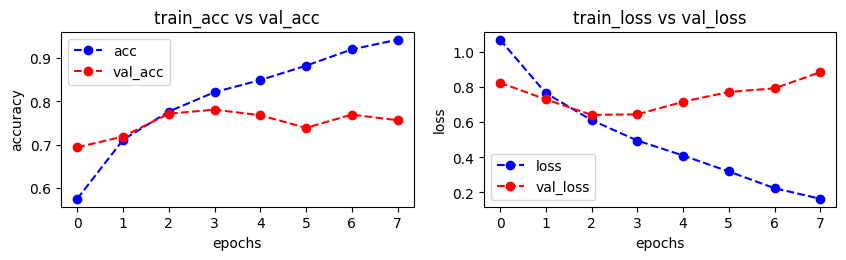

In [81]:
plot_accuracy_loss(history)
